In [1]:
import numpy as np
import skimage.io
import skimage.filters
import skimage.morphology
import pandas as pd
import sys
import scipy

import tqdm
import numba
import multiprocessing

from functools import partial


import time
##add the path containing Jwags video analysis files
sys.path.append("behavioral_analysis/")

import segmentation as jwseg 

import motmot.FlyMovieFormat.FlyMovieFormat as FMF

# Opening the flymovie file and creating a background image

What I've written below only works for behavioral videos with a single object. 

In [2]:
#File path the the video file
fname = '/data/2019_03_25_Lo_solo_5_mM_sulcatone_cam_0_date\
_2019_03_25_time_12_48_06_v001.fmf'

In [3]:
#create FMF object of the movie and get image dimensions
fmf = FMF.FlyMovie(fname)
frame_width = fmf.get_width()
frame_height = fmf.get_height()

In [4]:
image_labels = ['timestamp,s',
                'area',
                'bbox_min_row',
                'bbox_min_col',
                'bbox_max_row',
                'bbox_max_col',
                'bbox_area',
                'centroid_row',
                'centroid_col',
                'convex_area',
                'eccentricity',
                'equivalent_diameter',
                'euler_number',
                'extent',
                'filled_area',
                'label',
                'local_centroid_row',
                'local_centoid_col',
                'major_axis_length',
                'max_intensity',
                'mean_intensity',
                'min_intensity',
                'minor_axis_length',
                'orientation',
                'perimeter',
                'solidity',
                'weighted_centroid_row',
                'weighted_centroid_col',
                'weighted_local_centoid_row',
                'weighted_local_centroid_col']

In [5]:
#get the number of frames 
frame_num = fmf.get_n_frames()
frame_num

206500

In [6]:
bg_img_set = []
for frame_number in range(100):
    frame,timestamp = fmf.get_frame(frame_number)
    bg_img_set.append(frame)

In [7]:
bg_img = jwseg.construct_bg_img(bg_img_set)

/home/ubuntu/miniconda/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


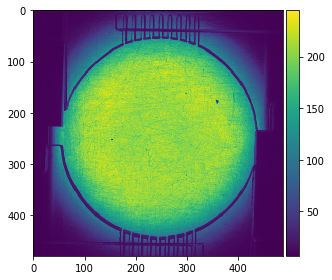

In [8]:
skimage.io.imshow(bg_img)

# Slightly modified functons written by Julian Wagner
Used to perform bg subtraction and meausure the region props of images

In [9]:
def bg_subtract(im1, im2):
    """Function to perform background subtraction on an image
    using a blank image of the arena of interest.
    
    Parameters
    ----------
    im1 : im, numpy.ndarray with shape (n, m) (with 0 < m, n)
        The image (with only one color chanel) to subtract the
        background from.
    im2 : im, numpy.ndarray with shape (n, m) (with 0 < m, n)
        The background image (with only one color chanel) to subtract the
        from im1.
    Returns
    -------
    output : 2d numpy.ndarray with shape (n, m)
        image with background subtracted, i.e. im1-im2.
    """
    im1 = normalize_convert_im(im1)
    im2 = normalize_convert_im(im2)
    
    im_no_bg = im1-im2
    #im_no_bg = normalize_convert_im(im_no_bg)
    return (im_no_bg)

In [10]:
def normalize_convert_im(im):
    """Function to normalize an image and convert it to float type.
    Normalized image is between 0. and 1.0.
    
    Parameters
    ----------
    im : numpy.ndarray with shape (n, m) (with 0 < m, n)
        The image (with only one color chanel) to get ROI from.
    
    Returns
    -------
    output : 2d numpy.ndarray with shape (n, m) of type float 
    and in range of 0. to 1.0.
    """
    
    im = skimage.img_as_float(im)
    im_norm = im - im.min()
    im_norm = im_norm / im_norm.max()
    return im_norm

In [11]:
def segment(im, thresh_func=skimage.filters.threshold_otsu, args=()):
    """Function to threshold an image using skimage functions. 
    The user pases the desired function to determine the threshold
    for the data (or a value to use as the threshold). This value
    for the threshold level can be a float/int or an array of same shape
    as the input image.
    
    Parameters
    ----------
    x : im, numpy.ndarray with shape (n, m) (with 0 < m, n)
        The image (with only one color chanel) to threshold.
    thresh_func : function
        The function to use to calculate the thresholding. Should
        return a single scalar value or a numpy array.
    Returns
    -------
    im_bw : 2d numpy.ndarray with shape (n, m)
        Boolean array with location of thresholded objects.
    im_labeled : a labelfield of image
    n_labels : number of identified objects in the labelfield
    """
    thresh = thresh_func(im, *args)
    im_bw = im < thresh
    
    #Remove small objects, i.e. insect legs that are recognized as separate objects
    #from the insect body
    im_bw_big_objs = skimage.morphology.remove_small_objects(im_bw)
    
    # Label binary image; background kwarg says value in im_bw to be background
    im_labeled, n_labels = skimage.measure.label(im_bw_big_objs, background=0, return_num=True)
    
    return im_bw, im_labeled, n_labels

In [12]:
def region_props_to_tuple(rp):
    """Function to extract the region properties from a regionprops
    object.
    
    Parameters
    ----------
    rp : skimage.measure._regionprops._RegionProperties, a region properties
        object from which to extract attributes
    Returns
    -------
    attributes : tuple. The regionproperty fields for many properites of a blob
    labels : tuple. The corresponding label for teh values in attributes
    """     
    labels = ('area', 'bbox_min_row', 'bbox_min_col', 'bbox_max_row', 'bbox_max_col', 'bbox_area',
              'centroid_row', 'centroid_col', 'convex_area', 'eccentricity', 'equivalent_diameter',
              'euler_number', 'extent', 'filled_area', 'label', 'local_centroid_row', 'local_centoid_col',
              'major_axis_length', 'max_intensity', 'mean_intensity', 'min_intensity', 'minor_axis_length',
              'orientation', 'perimeter', 'solidity', 'weighted_centroid_row', 'weighted_centroid_col',
              'weighted_local_centoid_row', 'weighted_local_centroid_col')
    
    bbox_min_row, bbox_min_col, bbox_max_row, bbox_max_col = rp.bbox
    centroid_row, centroid_col = rp.centroid
    local_centroid_row, local_centoid_col = rp.local_centroid
    weighted_centroid_row, weighted_centroid_col = rp.weighted_centroid
    weighted_local_centoid_row, weighted_local_centroid_col = rp.weighted_local_centroid

    attributes = (rp.area, bbox_min_row, bbox_min_col, bbox_max_row, bbox_max_col,
                  rp.bbox_area, centroid_row, centroid_col, rp.convex_area, 
                  rp.eccentricity, rp.equivalent_diameter, rp.euler_number,
                  rp.extent, rp.filled_area, rp.label, local_centroid_row,
                  local_centoid_col, rp.major_axis_length, rp.max_intensity,
                  rp.mean_intensity, rp.min_intensity, rp.minor_axis_length,
                  rp.orientation, rp.perimeter, rp.solidity,
                  weighted_centroid_row, weighted_centroid_col,
                  weighted_local_centoid_row, weighted_local_centroid_col)
    
    return attributes, labels

## Creating a function that combines the above functions into something that can be multithreaded

In [13]:
def image_analysis(curr_im, bg_im):
    """Combines functions to perform background subtraction of an image
    threshold the image, identify objects in the thresholded image,
    and generate region props for the image
    
    Parameters
    ----------
    curr_im : current image being analyzed
    bg_im : background image generated from dataset
    
    Returns
    -------
    attributes : tuple. The regionproperty fields for many properites of a blob
    labels : tuple. The corresponding label for teh values in attributes
    """     

    #If the frame is empty, return nans for frame_attributes
    if np.max(curr_im == 0):
        frame_attributes = np.empty(29)*np.nan
    else:
        frame_nobg = bg_subtract(curr_im, bg_im)
    
        #find the min-max differential of the bg subtracted image
        #Because both images are normalized between 0 and 1 before
        #subtraction, the background will have a value of zero and
        #any ants should have a pixel intensity of around 1.
        #I will use a min-max differential of 0.5 to identify
        #frames without an ant
        min_max_differential = np.max(frame_nobg)-np.min(frame_nobg)
        
        #If there is no ant, i.e. min_max_differential <= 0.5
        #return an array of zeros for frame_attributes
        if min_max_differential <= 0.5:
            frame_attributes = np.zeros(29)
        else:
            #normalize bg subtracted image between 0-1
            frame_nobg = normalize_convert_im(frame_nobg)
            
            frame_thresh,frame_label,label_nums = segment(frame_nobg)
    
            frame_rp = skimage.measure.regionprops(frame_label,frame_nobg)
    
            frame_attributes,_ = region_props_to_tuple(frame_rp[0])
    
    return frame_attributes

# Load every frame from fly movie format into RAM

In [14]:
#create list that will contain tuples of all images and timestamps
image_tmstmp_list = []

#load every frame and timestamp of the video into a list in RAM
for frame_number in tqdm.tqdm_notebook(range(frame_num)):
    frame_tmstmp_hold = fmf.get_frame(frame_number)
    image_tmstmp_list.append(frame_tmstmp_hold)

In [15]:
test_list = image_tmstmp_list[300:10300]

In [15]:
#Attempting to write up a function for running the image analyses in parallel
def image_analysis_parallel(bgim_par, im_time_tuple):
    """This function takes as input a background image and a tuple
    containing an image and corresponding timestamp. Calling this function
    using the pool.map function, the iterable, ie the list of tuples containing
    the image and timestampt, will be automatically iterated through, with each
    subsequent entry being passed to this function. The output of this function
    is a pandas dataframe with the image labels as column headings and the entry
    for a single image as the row
    
    Parameters
    ----------
    bgim_par : a background image for the behavioral arena being used. Generated
                using the jwseg.construct_bg_img function written by Julian 
                Wagner
                
    im_time_tuple : a tuple containing an image array corresponding to a single
                    frame from a behavioral video and the corresponding timestamp
    
    Returns
    -------
    dataframe :A pandas dataframe with a header will be returned"""
    
    im_list_par,tmstmp_par = im_time_tuple
    
    #output_array = ([tmstmp_par, *image_analysis(im_list_par, bgim_par)])
    
    #return pd.DataFrame(*output_array, columns=['timestamp, s',*image_labels])
    
    #return output array that contains a list of the timestamp and each of the 
    #frame attributes
    return [tmstmp_par, *image_analysis(im_list_par, bgim_par)]
    

In [16]:
t = time.time()
#I'm using map instead of imap. Map generates a list that is returned 
#after the iterable has been run through in its entirety. imap 
#saves out to a second iterable over the course of running through the 
#first iterable and is thus available throughout the run.
with multiprocessing.Pool() as pool:

    #Creating a partial function from image_analysis_parallel
    #The pool.map process can only take a single iterable as input
    #and doesn't take any other arguments. Image_analysis_parallel
    #also requires the background image, which isn't an iterable
    #by creating a partial function, I can feed in the background
    #image to the main function and then feed in the iterable to the
    #partial function
    partial_func = partial(image_analysis_parallel, bg_img)
    
    output_data = pool.map(partial_func, image_tmstmp_list)
    
out_df = pd.DataFrame(output_data,columns = image_labels)
elapsed = time.time() - t
elapsed

/home/ubuntu/miniconda/lib/python3.7/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/home/ubuntu/miniconda/lib/python3.7/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/home/ubuntu/miniconda/lib/python3.7/site-packages/skimage/measure/_regionprops.py:250: 

1787.9918580055237

In [18]:
out_df.to_csv('~/sceptovideo/2019_03_25_Liometopum_solo_5mM_sulcatone_run_01.csv')

In [17]:
t = time.time()
test_output = [[curr_im_time[1], *image_analysis(curr_im_time[0], bg_img)] \
               for i,curr_im_time in enumerate(image_tmstmp_list)]
   
test_out_df = pd.DataFrame(test_output,columns = image_labels)
elapsed = time.time() - t
elapsed 

/home/ubuntu/miniconda/lib/python3.7/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/home/ubuntu/miniconda/lib/python3.7/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


3712.159764289856

In [121]:
test_out_df.head()

,"timestamp,s",area,bbox_min_row,bbox_min_col,bbox_max_row,bbox_max_col,bbox_area,centroid_row,centroid_col,convex_area,...,mean_intensity,min_intensity,minor_axis_length,orientation,perimeter,solidity,weighted_centroid_row,weighted_centroid_col,weighted_local_centoid_row,weighted_local_centroid_col
0,3.571441,560,268,79,319,113,1734,295.917857,95.542857,1117,...,0.233599,0.0,20.369097,-1.257401,237.645707,0.501343,296.517853,95.839613,28.517853,16.839613
1,3.583345,564,266,79,320,114,1890,295.992908,95.991135,1271,...,0.231791,0.0,21.517128,-1.273680,236.988853,0.443745,295.844005,96.297814,29.844005,17.297814
2,3.595250,571,270,79,326,120,2296,297.681261,96.434326,1278,...,0.227460,0.0,21.285126,-1.219382,237.817280,0.446792,298.742539,97.103642,28.742539,18.103642
3,3.607155,565,276,79,326,120,2050,298.270796,96.375221,1220,...,0.233691,0.0,20.991859,-1.204276,232.817280,0.463115,299.640843,96.914370,23.640843,17.914370
4,3.619060,536,277,79,321,114,1540,298.152985,95.981343,1033,...,0.220080,0.0,19.459629,-1.228037,213.852814,0.518877,299.079926,96.092457,22.079926,17.092457


In [43]:
frame,_ = fmf.get_frame(20000)
frame_nobg = bg_subtract(frame, bg_img)
    
frame_thresh,frame_label,label_nums = segment(frame_nobg)
    

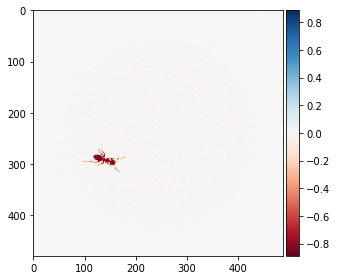

In [44]:
skimage.io.imshow(frame_nobg)

In [39]:
np.max(frame_nobg)-np.min(frame_nobg)

0.8730964467005076

In [42]:
np.max(frame_nobg)-np.min(frame_nobg)

0.12939086294416258

In [45]:
np.max(frame_nobg)-np.min(frame_nobg)

1.0019386271458819